## Machine Learning Assignment 4 Coding Part

This Jupyter Notebook contains the coding part of Assignment 4. Please enter your name and student ID here:

- Name: 朱云飞
- StudentID:122090907

### Overview

In the coding part of Assignment 4, you'll complete the following four tasks:

- **Task 1**: Implement $k$​​​-means.
- **Task 2**: Implement $k$-means++ initialization.
- **Task 3**: Implement a Gaussian Mixture Model.

The following code is incomplete, and you are required to fill in the missing parts. Please feel free to define your own functions or modify the functions given if needed. You may not use off-the-shelf libraries for all three tasks.

### Data Format

We will be working with a toy dataset with features in $\mathbb R^2$. Before you begin, download the following files.
- `train.txt` the training set, containing 4800 samples.
- `dev.txt` the development set, containing 800 samples.

Each line of the files stores a sample in the format `feature_1,feature_2`.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from numpy import ndarray
from typing import Tuple, Union, Type, Dict

In [4]:
def read_file(file_path: str, types: Tuple[Type, ...]) -> Tuple[ndarray, ...]:
    """Read a text file with lines containing comma separated numerical values.
    Args:
        file_path (str): The file path.
        types (Tuple[Type]): The types of each column, for example, (float, float, int).
    Returns:
        columns (Tuple[ndarray, ...]): Numpy arrays of shape [N_lines].
    """
    with open(file_path, "r") as f:
        items = [line.strip().split(",") for line in f.readlines()]
        items = [tuple(type(e) for type, e in zip(types, t)) for t in items]
    columns = list(zip(*items))
    return tuple(np.asarray(c) for c in columns)

# Load the dataset from files
train_x1, train_x2 = read_file("/content/drive/MyDrive/DDA3020/train.txt", (float, float))
train_x = np.stack((train_x1, train_x2), axis=1)
dev_x1, dev_x2 = read_file("/content/drive/MyDrive/DDA3020/dev.txt", (float, float))
dev_x = np.stack((dev_x1, dev_x2), axis=1)

### Visualization of the Training Set

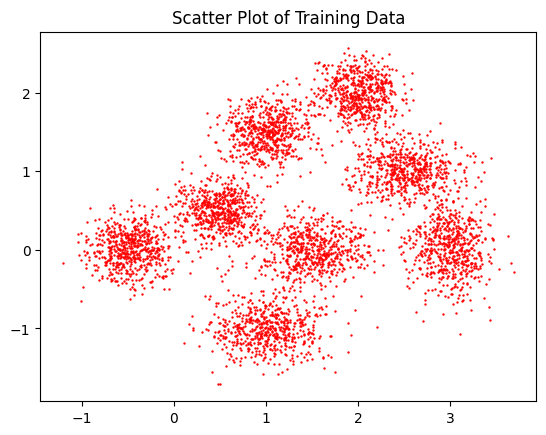

In [5]:
plt.scatter(train_x[:, 0], train_x[:, 1], c="red", s=0.5)
plt.title("Scatter Plot of Training Data")
plt.show()

### Task 1: Implement $k$-means

For $\mathbf x \in \mathbb R^D$ and finite set $\mathcal C \subset \mathbb R^D$ define $d(\mathbf x, \mathcal C) := \min_{\mathbf c \in \mathcal C} \|\mathbf x - \mathbf c\|_2$.

For finite set $\mathcal X \subset \mathbb R^D$ and finite set $\mathcal C \subset \mathbb R^D$ define $\phi(\mathcal X, \mathcal C) := \sum_{\mathbf x \in \mathcal X} d^2(\mathbf x, \mathcal C)$.

Given $\mathcal X = \{\mathbf x_1, \cdots, \mathbf x_N\} \subset \mathbb R^D$, $k$-means optimizes $\mathcal C \subset \mathbb R^D$, where $|\mathcal C| = K$, to minimize the following loss:
$$
\mathcal L(\mathcal C) = \phi(\mathcal X, \mathcal C) = \sum_{\mathbf x \in \mathcal X} \min_{\mathbf c \in \mathcal C} \|\mathbf x - \mathbf c\|_2^2
$$

#### Subtasks
1. Implement the `solve_k_means()` function in the following code block.
2. Plot the loss $\mathcal L$ as a function the number of updates to $\mathcal C$.
3. Generate a scatter plot of the training samples and cluster centers, after $k$-means converges to a **global minimum**.
4. Run $k$-means multiple times. How frequently does the algorithm converge to a global minimum?

In [18]:
def solve_k_means(
    x: ndarray, c: ndarray, *, max_step: int=10000
) -> Tuple[ndarray, ndarray, list]:
    """K-means solver. Given K initial cluster centers, update c iteratively.
    Note:
        - You may change the function signature.
        - Please try your best to write vectorized code (i.e. avoid for loops over indices).
        - Design some criterion for stopping the iteration.
    Args:
        x (ndarray[float]): shape [N, D], storing N data samples. D is the feature dimension.
        c (ndarray[float]): shape [K, D], storing K initial cluster centers.
        max_step (int): Maximum number of steps in $k$-means iteration.
    Returns:
        c (ndarray[float]): shape [K, D], updated K cluster centers after iterations.
        index (ndarray[int]): shape [N], the index of the nearest cluster center of
            each sample, in range {0, ..., K - 1}.
    """
    N, D = x.shape
    K = c.shape[0]
    losses = []
    index = np.zeros(N, dtype=int)
    prev_c = np.zeros_like(c)
    for step in range(max_step):
        distances = np.linalg.norm(x[:, np.newaxis] - c, axis=2)  # Shape (N, K)
        new_index = np.argmin(distances, axis=1)
        if np.array_equal(index, new_index):
            break
        index = new_index
        for k in range(K):
            c[k, :] = np.mean(x[index == k], axis=0)
        loss = np.sum((x - c[index])**2)
        losses.append(loss)
    return c, index, losses

In [19]:
# Random (standard Normal) initialization:
def standard_normal_initialization(K: int) -> ndarray:
    """Standard normal initialization of K cluster centers.
    Args:
        K (int): number of cluster centers.
    Returns:
        c (ndarray): shape [K, 2], K initial cluster centers.
    """
    return np.random.randn(K, 2)

In [210]:
# Run k-means with random initialization:
init_c = standard_normal_initialization(8)
updated_c, index, loss_history = solve_k_means(train_x, init_c, max_step=1000)

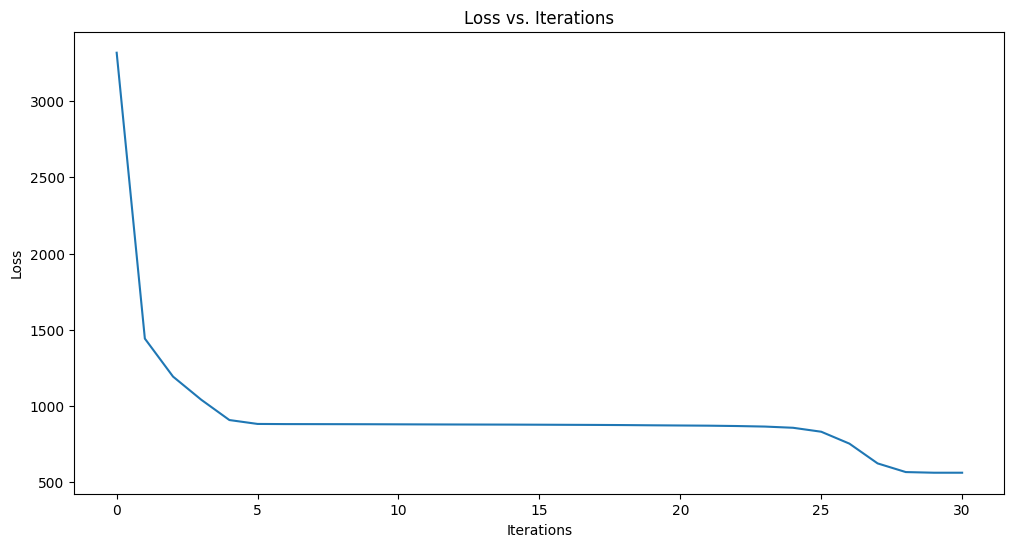

In [211]:
plt.figure(figsize=(12, 6))
plt.plot(loss_history)
plt.title('Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

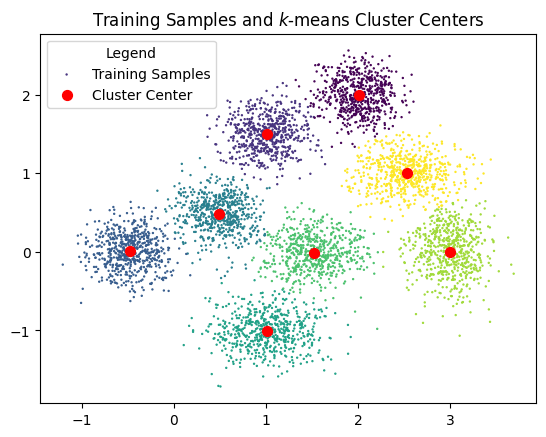

In [212]:
# Plot out the training samples and the cluster centers.
plt.scatter(train_x[:, 0], train_x[:, 1], c=index, s=0.5, label="Training Samples")
plt.scatter(updated_c[:, 0], updated_c[:, 1], c="red", s=50, label="Cluster Center", marker="o")

plt.legend(title="Legend")
plt.title("Training Samples and $k$-means Cluster Centers")
plt.show()

### Task 2: Implement $k$-means++

$k$-means is sensitive to its initialization, and a random initialization of $\mathbf c$ often results in convergence to a local minimum. $k$-means++ is an improved initialization method that often leads to better convergence. Read more about it in [Scalable K-Means++](https://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf).

**(Algorithm)** Given $\mathcal X$, $k$-means++ generates a set of $k$ vectors $\mathcal I$ in $\mathbb R^D$ using the following steps:
1. First, randomly pick a sample $\mathbf x$ from $\mathcal X$. And set $\mathcal I := \{\mathbf x\}$.
2. While $|\mathcal I| < k$. Sample $\mathbf x \in \mathcal X$ with probability $p(\mathbf x) := d^2(\mathbf x, \mathcal I) / \phi(\mathcal X, \mathcal I)$. And add the sampled $\mathbf x$ to set $\mathcal I$.

#### Subtasks
1. Implement $k$-means++ initialization algorithm.
2. Compare the loss $\mathcal L$ after convergence with standard normal initialization and $k$-means++ initialization.
3. Compare the convergence speed with random and $k$-means++ initialization.

In [236]:
import random
def k_means_pp_initialization(x: ndarray, K: int) -> ndarray:
    """K-means++ initialization method.
    Args:
        x (ndarray): shape [N, D], storing N data samples. D is the feature dimension.
        K (int): Number of cluster centers.
    Returns:
        c (ndarray): shape [K, D], K initial cluster centers generated by K-means++.
    """
    N, D = x.shape
    centers = np.zeros((K, D))

    idx = np.random.choice(N)
    centers[0] = x[idx]
    losses = []

    sq_distances = np.linalg.norm(x - centers[0], axis=1) ** 2

    for k in range(1, K):
        probabilities = sq_distances / np.sum(sq_distances)
        idx = np.random.choice(N, p=probabilities)
        centers[k] = x[idx]

        new_sq_distances = np.linalg.norm(x - centers[k], axis=1) ** 2
        sq_distances = np.minimum(sq_distances, new_sq_distances)

    return centers

In [279]:
# Initialize the cluster centers with k-means++, then do k-means updates.
init_c = k_means_pp_initialization(train_x, 8)
updated_c, index, loss_history = solve_k_means(train_x, init_c, max_step=1000)

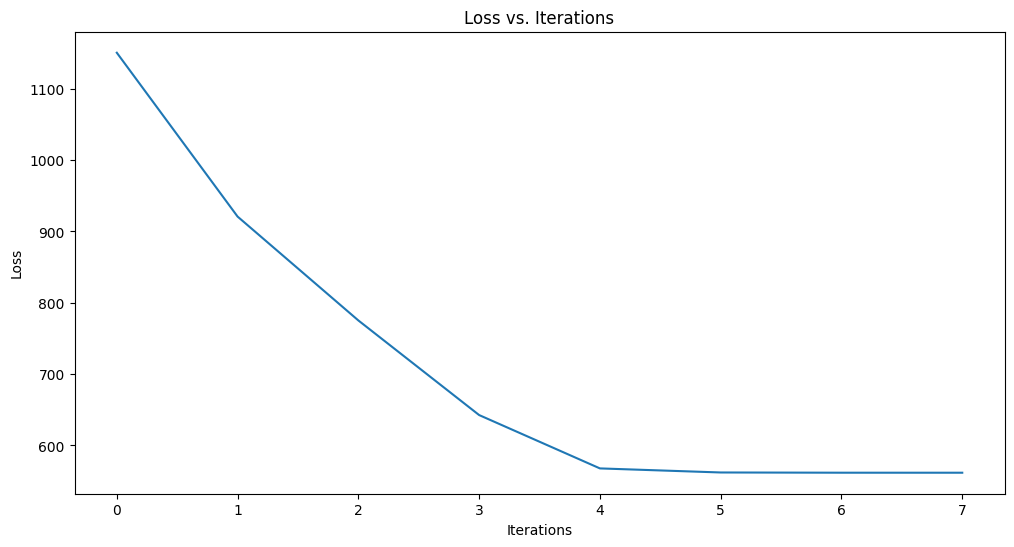

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(loss_history)
plt.title('Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

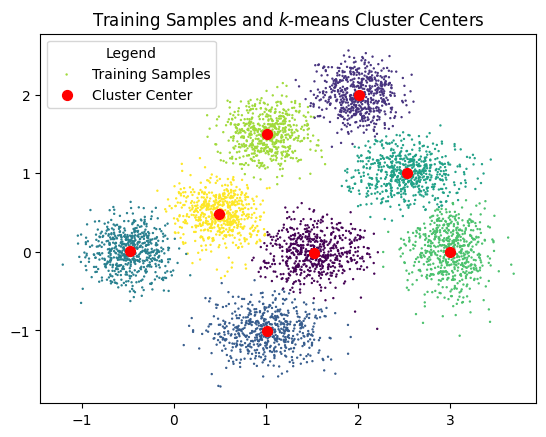

In [281]:
# Plot out the training samples and the cluster centers.
plt.scatter(train_x[:, 0], train_x[:, 1], c=index, s=0.5, label="Training Samples")
plt.scatter(updated_c[:, 0], updated_c[:, 1], c="red", s=50, label="Cluster Center", marker="o")

plt.legend(title="Legend")
plt.title("Training Samples and $k$-means Cluster Centers")
plt.show()

### Task 3: Implement a Gaussian Mixture Model

In this task, you will implement the Expectation-Maximization (EM) algorithm for learning a Gaussian Mixture Model (GMM). Our GMM in $\mathbb R^2$ has a density given by:

$$
p(x) = \sum_{k = 1}^K \pi_k \mathcal N(x| \mu_k, \Sigma_k), \quad \mu_k \in \mathbb R^2, \quad \Sigma_k \in \mathbb R^{2 \times 2}
$$

#### Subtasks
1. Implement EM algorithm. Hint: initialize the Gaussian means with $k$-means++ for better convergence.
2. Use the provided `plot_gmm_contour` function to generate a 2D contour plot of the GMM density $p(x)$ after the log likelihood convergence to a global maximum. You may use `gmm_log_prob` to compute log probability of the GMM.
3. Report the log-likelihood on the training set and development set.

In [282]:
from scipy.stats import multivariate_normal

In [283]:
def gmm_log_prob(x: ndarray, pi: ndarray, mu: ndarray, sigma: ndarray) -> ndarray:
    """Batched computation of GMM log probability.
    Arg:
        x (ndarray): [..., 2]. Each sample is a vector in R^2.
        pi (ndarray): [K], mixture weights in the GMM, pi.sum() = 1.
        mu (ndarray): [K, 2], means of Gaussian components.
        sigma (ndarray): [K, 2, 2], covariance matrix of Gaussian components.
            Each sigma[k] must be symmetric positive definite.
    Returns:
        log_prob (ndarray): [...]. The log probability of each vector in x.
            Has the same shape as x after removing the last dimension of x.
    """
    mix = torch.distributions.Categorical(probs=torch.as_tensor(pi))
    normals = torch.distributions.MultivariateNormal(
        loc=torch.as_tensor(mu), covariance_matrix=torch.as_tensor(sigma)
    )
    gmm = torch.distributions.MixtureSameFamily(mix, normals)
    return gmm.log_prob(torch.as_tensor(x)).numpy()

In [284]:
def plot_gmm_contour(x: ndarray, pi: ndarray, mu: ndarray, sigma: ndarray) -> None:
    """Generate a contour plot of the GMM probability, overlapped with a scatter plot
        of the samples in x.
    Args:
        x (ndarray): [N, 2].
        pi (ndarray): [K], mixture weights in the GMM, pi.sum() = 1.
        mu (ndarray): [K, 2], means of Gaussian components.
        sigma (ndarray): [K, 2, 2], covariance matrix of Gaussian components.
            Each sigma[k] must be symmetric positive definite.
    """
    grid_1 = np.arange(-1.5, 4, 0.01)  # [Gx]
    grid_2 = np.arange(-2, 3, 0.01)  # [Gy]
    grid_11, grid_22 = np.meshgrid(grid_1, grid_2, indexing="ij")  # [Gx, Gy]
    grid_12 = np.stack([grid_11, grid_22], axis=-1)  # [Gx, Gy, 2]

    grid_logp = gmm_log_prob(grid_12, pi, mu, sigma)  # [Gx, Gy, 2]

    # Plot the contour
    plt.figure(figsize=(7, 4))
    plt.contour(grid_1, grid_2, np.exp(grid_logp.transpose()), levels=10, cmap='viridis')
    plt.scatter(x[:, 0], x[:, 1], c="red", s=0.1, label="Training Samples")
    plt.scatter(mu[:, 0], mu[:, 1], c="black", s=50, label="Gaussian Means")
    plt.legend()  # Add legend
    plt.title("Contour Plot of GMM Probability with Training Samples")
    plt.colorbar()
    plt.show()

In [285]:
def initialize_parameters(x, K):
  n, d = x.shape
  means = k_means_pp_initialization(x, K)
  covariances = np.array([np.eye(d) * np.var(x, axis=0).mean() for _ in range(K)])
  weights = np.full(K, 1/K)
  return weights, means, covariances

In [286]:
def e_step(x, weights, means, covariances):
  n = x.shape[0]
  K = len(weights)
  responsibilities = np.zeros((n, K))
  for k in range(K):
    responsibilities[:, k] = weights[k] * multivariate_normal(means[k], covariances[k]).pdf(x)
  responsibilities /= responsibilities.sum(axis=1, keepdims=True)
  return responsibilities

In [287]:
def m_step(x, responsibilities):
  n, d = x.shape
  K = responsibilities.shape[1]
  n_k = responsibilities.sum(axis=0)
  weights = n_k / n
  means = np.dot(responsibilities.T, x) / n_k[:, None]
  covariances = np.zeros((K, d, d))
  for k in range(K):
    x_centered = x - means[k]
    covariances[k] = np.dot(responsibilities[:, k] * x_centered.T, x_centered) / n_k[k]
  return weights, means, covariances

In [288]:
def log_likelihood(x, weights, means, covariances):
  n = x.shape[0]
  K = len(weights)
  log_likelihood = 0
  for k in range(K):
    log_likelihood += weights[k] * multivariate_normal(means[k], covariances[k]).pdf(x)
  return np.log(log_likelihood).sum()

In [289]:
def expectation_maximization(x, K, max_iter=100, tol=1e-4):
  weights, means, covariances = initialize_parameters(x, K)
  log_likelihood_history = []

  for _ in range(max_iter):
    responsibilities = e_step(x, weights, means, covariances)
    weights, means, covariances = m_step(x, responsibilities)
    ll = log_likelihood(x, weights, means, covariances)
    if log_likelihood_history and np.abs(ll - log_likelihood_history[-1]) < tol:
      break
    log_likelihood_history.append(ll)

  return means, covariances, weights, log_likelihood_history[-1]

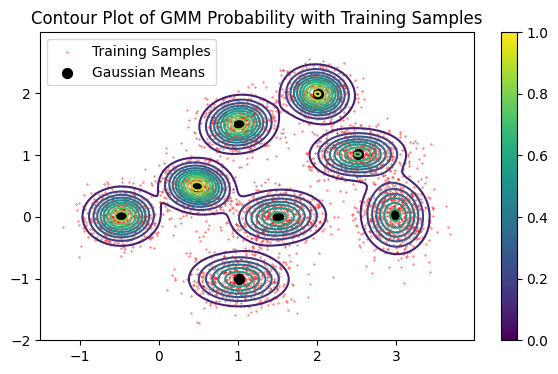

In [293]:
mu, sigma, pi, train_ll = expectation_maximization(train_x, K=8)
plot_gmm_contour(train_x, pi, mu, sigma)

In [294]:
print(f"Log-likelihood on the training set: {train_ll}")
dev_ll = gmm_log_prob(dev_x, pi, mu, sigma).sum()
print(f"Log-likelihood on the development set: {dev_ll}")

Log-likelihood on the training set: -9693.226261958467
Log-likelihood on the development set: -1678.018134965429
